[*********************100%***********************]  1 of 1 completed
2022-01-03 21:00:00+00:00    3703.732666
2022-01-06 01:00:00+00:00    3544.766357
2022-01-17 22:00:00+00:00    3171.340820
2022-01-21 00:00:00+00:00    3002.956787
2022-02-11 01:00:00+00:00    3039.226318
2022-02-17 15:00:00+00:00    2975.887451
2022-03-04 01:00:00+00:00    2738.572510
2022-03-11 03:00:00+00:00    2539.735352
2022-03-20 15:00:00+00:00    2864.692383
2022-03-31 17:00:00+00:00    3287.038330
2022-04-06 01:00:00+00:00    3331.624268
2022-04-11 03:00:00+00:00    3163.453857
2022-04-21 23:00:00+00:00    2982.973633
2022-04-26 16:00:00+00:00    2870.969238
2022-05-05 16:00:00+00:00    2745.343506
2022-05-24 14:00:00+00:00    1934.866455
2022-06-01 17:00:00+00:00    1859.260010
2022-06-07 01:00:00+00:00    1757.076050
2022-06-30 07:00:00+00:00    1060.624512
2022-07-10 15:00:00+00:00    1159.429199
2022-07-26 00:00:00+00:00    1444.100098
2022-08-01 20:00:00+00:00    1623.572021
2022-08-09 12:00:00+00:00    

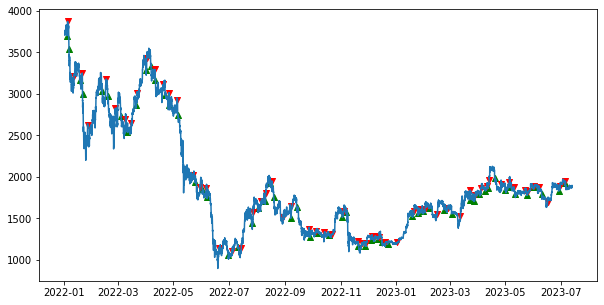

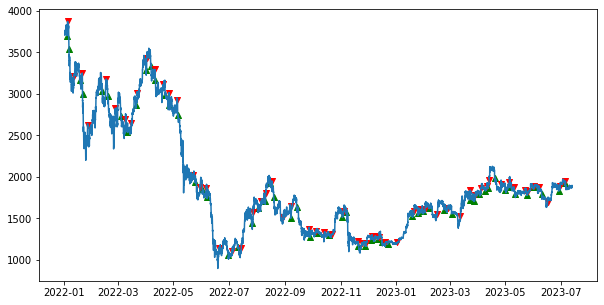

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt


class Backtest:
    def __init__(self, symbol):
        self.symbol = symbol
        self.df = yf.download(self.symbol, start='2022-01-01',period = "2m",interval = "1h")
        if self.df.empty:
            print('No data pulled')
        else:
            self.calc_indicators()
            self.generate_signals()
            self.loop_it()
            self.profit = self.calc_profit()
            self.max_dd = self.profit.min()
            self.cumul_profit = (self.profit + 1).prod() - 1
            self.plot_chart()


    def calc_indicators(self):
        self.df['ma_20'] = self.df.Close.rolling(20).mean()
        self.df['vol'] = self.df.Close.rolling(20).std()
        self.df['upper_bb'] = self.df.ma_20 + (2 * self.df.vol)
        self.df['lower_bb'] = self.df.ma_20 - (2 * self.df.vol)
        self.df['rsi'] = ta.RSI(self.df.Close)
        self.df.dropna(inplace=True)

    def generate_signals(self):
        conditions = [(self.df.rsi < 30) & (self.df.Close < self.df.lower_bb),
                      (self.df.rsi > 70) & (self.df.Close > self.df.upper_bb)]
        choices = ['Buy', 'Sell']
        self.df['signal'] = np.select(conditions, choices)
        self.df.signal = self.df.signal.shift()
        self.df.dropna(inplace=True)

    def loop_it(self):
        position = False
        buydates, selldates = [], []

        for index, row in self.df.iterrows():
            if not position and row['signal'] == 'Buy':
                position = True
                buydates.append(index)
            if position and row['signal'] == 'Sell':
                position = False
                selldates.append(index)

        self.buy_arr = self.df.loc[buydates].Open
        self.sell_arr = self.df.loc[selldates].Open

    def calc_profit(self):
        if self.buy_arr.index[-1] > self.sell_arr.index[-1]:
            self.buy_arr = self.buy_arr[:-1]
        return (self.sell_arr.values - self.buy_arr.values) / self.buy_arr.values

    def plot_chart(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.df.Close)
        plt.scatter(self.buy_arr.index, self.buy_arr.values, marker='^', c='g')
        plt.scatter(self.sell_arr.index, self.sell_arr.values, marker='v', c='r')


instance = Backtest('ETH-USD')

print(instance.buy_arr)

print(instance.sell_arr)

print(instance.profit)

print(instance.cumul_profit)

instance.plot_chart()